## 6.1 One hot encoding

In [25]:
import numpy as np
import string
import os
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
import matplotlib.pyplot as plt

In [19]:
# One hot encoding for words.
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
token_index = {}
for sample in samples:
    # tokenize with split. In a real application punctionation and special character should be stripped.
    for word in sample.split():
        if word not in token_index:
            # Assign indexes to words. 0 is skipped.
            token_index[word] = len(token_index) + 1
# Max length of samples.
max_length = 10
# Note: since no word has index 0 one hot vectors have to have size of max index + 1
# Results:[samples, words in sample, one hot vectors]
results = np.zeros(shape=(len(samples), max_length, max(token_index.values())+1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.


In [31]:
# One hot encoding for characters.
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters, range(1,len(characters)+1)))
max_length = 50
results = np.zeros(shape=(len(samples), max_length, max(token_index.values())+1))
for i, sample in enumerate(samples):
    for j, character in list(enumerate(sample))[:max_length]:
        index = token_index.get(character)
        results[i, j, index] = 1.


Keras can do these things while stripping special characters and using N most common words.

In [41]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

Found 9 unique tokens


A variant of one hot encoding is the one hot hashing trick where we dont keep a dictionary of known words but calculate their hash using some algorithm. This means we can encode data online but it is possible that two words could have the same hash.

In [46]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## 6.1.2. using word embedings

In [2]:
max_features = 1000
maxlen = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
model = Sequential()
model.add(Embedding(1000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=16,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             8000      
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 8,161
Trainable params: 8,161
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 172us/step - loss: 0.6546 - acc: 0.6291 - val_loss: 0.5899 - val_acc: 0.6946
Epoch 2/10
20000/20000 [==============================] - 2s 88us/step - loss: 0.5356 - acc: 0.7341 - val_loss: 0.5367 - val_acc: 0.7238
Epoch 3/10
20000/20000 [========

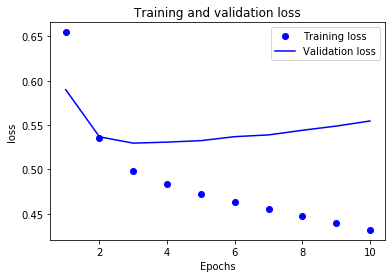

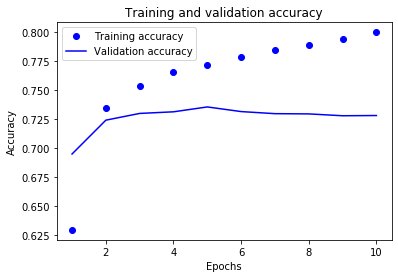

In [7]:
def plot_history(history):
    def plot_history_record(history, record, *args, **kwargs):
        values = history.history[record]
        epochs = range(1, len(values) + 1)
        plt.plot(epochs, values, *args, **kwargs)

    plot_history_record(history, 'loss', 'bo', label='Training loss')
    plot_history_record(history, 'val_loss', 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.figure()
    plot_history_record(history, 'acc', 'bo', label='Training accuracy')
    plot_history_record(history, 'val_acc', 'b', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
plot_history(history)

We achived valdiation accuracy of 72% buy looking at only 20 words. Part of the resen is that we used a simple dense clasiffier instead of using an RNN od 1D conv layer that could take into account the inter word relationships.

## Pretrained embeddings

Download the IMDB reviews from http://mng.bz/0tI0 and uncompress into datasets.

In [9]:
imdb_dir = 'datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['pos', 'neg']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name,fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [39]:
maxlen = 100
# Simulate small dataset.
training_samples = 200
validation_samples = 10000
max_words = 10000

# Use a tokenizer to extraxt seqences from texts.
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Pad seqences to maxlen (100 words).
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print(f"Shape of data tensor: {data.shape}")
print(f"Shape of label tensor: {labels.shape}")

# Shuffle data.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Dowload GloVe from https://nlp.stanford.edu/projects/glove/ . You need to download glove.6B.zip. GloVe is a word embedding calculated from 2014 english wikipedia.

In [29]:
glove_dir = 'datasets/glove.6B'

# Build an embeddings_index by reading 100d glove file. It consists of word followed by embedding.
embeddings_index = {}
with open(os.path.join(glove_dir,'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Build embedding matrix that can be loaded int an embedding layer. It is of shape (max_words. embedding_dim) each entry i contains the embedding of ith word from the word index.

In [30]:
embeddings_dim = 100
# For all words look into embeddings index and if you find the word store it into embeddings matrix.
embeddings_matrix = np.zeros((max_words, embeddings_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

In [34]:
model = Sequential()
model.add(Embedding(max_words,embeddings_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Load glove matrix into embedding layer.
model.layers[0].set_weights([embeddings_matrix])
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.5768 - acc: 0.4550 - val_loss: 0.9384 - val_acc: 0.4997
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.7803 - acc: 0.6100 - val_loss: 0.9704 - val_acc: 0.4997
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6129 - acc: 0.6450 - val_loss: 0.9238 - val_acc: 0.5007
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5226 - acc: 0.6750 - val_loss: 0.9923 - val_acc: 0.4987
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4814 - acc: 0.7000 - val_loss: 0.9814 - val_acc: 0.5013
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.4457 - acc: 0.7200 - val_loss: 1.0526 - val_acc: 0.5013
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4443 - acc: 0.6950 - val_loss: 1.0181 - val_acc: 0.5020
Epoch 8/10
200/200 [========

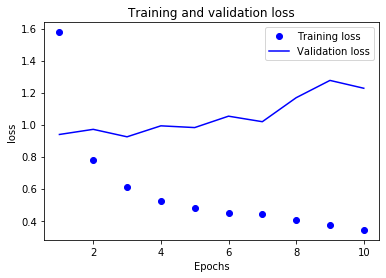

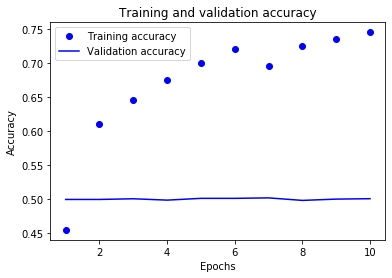

In [40]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')
plot_history(history)

Model quickly overfits due to really small dataset. Also it achieves 50% accuracy which fails to beat a random baseline.

We could unfreeze the embedigs(it wouldnt help due to small dataset, otherwise it would.)

In [41]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['pos', 'neg']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name,fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)

x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 1s 31us/step


[1.0664349506378175, 0.51076]

Test accuracy is 51% marginally better than a random baseline. Cause is small dataset cupled with wrong approach to sequences.